# LSTM baseline

from kuto

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
import os
import sys
import glob
import pickle
import random

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path


In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
import pytorch_lightning as pl
# from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import wandb
from pytorch_lightning.loggers import WandbLogger

In [6]:
sys.path.append('../../')
import src.utils as utils

In [7]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm

from indoor_location_competition_20.io_f import read_data_file
import indoor_location_competition_20.compute_f as compute_f

In [8]:
DATA_DIR = Path("/home/knikaido/work/Indoor-Location-Navigation/data/")
WIFI_DIR = DATA_DIR / 'indoorunifiedwifids_original'
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'
OUTPUT_DIR = Path('./output/')
MLFLOW_DIR = DATA_DIR / 'mlflow/mlruns'

## config

In [9]:
configs = {
    'loss':{
        'name': 'MSELoss',
        'params':{}
    },
    'optimizer':{
        'name': 'Adam',
        'params':{
            'lr': 0.01,
        }
    },

    'scheduler':{
        'name': 'ReduceLROnPlateau',
        'params':{
            'factor': 0.1,
            'patience': 3,
        }
    },

    'loader':{
        'train':{
            'batch_size': 512,
            'shuffle': True,
            'num_workers': 4,
        },
        'valid':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        },
        'test':{
            'batch_size': 512,
            'shuffle': False,
            'num_workers': 4,
        }
    }
}

In [10]:
# config
config = configs

# globals variable
SEED = 777
MAX_EPOCHS = 500
N_SPLITS = 5
DEBUG = False
# EXP_MESSAGE = config['globals']['exp_message']

EXP_NAME = 63
IS_SAVE = True

utils.set_seed(SEED)

In [11]:
!wandb login e8aaf98060af90035c3c28a83b34452780aeec20

/bin/sh: 1: wandb: not found


## read data

In [12]:
train_df = pd.read_csv(WIFI_DIR / 'train_10_th10000_base25_withpassedtime_withdelta.csv')
test_df = pd.read_csv(WIFI_DIR / 'test_10_th10000_base25_withpassedtime_allwifibase_withdelta.csv')

In [13]:
sub = pd.read_csv(DATA_DIR/'indoor-location-navigation/sample_submission.csv', index_col=0)

BSSIDとRSSIは100ずつ存在しているけど全てが必要なわけではないみたい  
ここでは20だけ取り出している。

In [14]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]
DELTA_FEATS  = ['delta_x', 'delta_y']

In [15]:
bad_index = np.load('../54/output/oof54_badindex.npy')

In [16]:
train_df = train_df.drop(bad_index).reset_index(drop=True)

bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない


In [17]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100, 200):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100, 200):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 61421
BSSID TYPES(test): 28283
BSSID TYPES(all): 89704


In [18]:
# get numbers of bssids to embed them in a layer

# train
rssi_bssids = []
# bssidを列ごとにリストに入れていく
for i in RSSI_FEATS:
    rssi_bssids.extend(train_df.loc[:,i].values.tolist())
rssi_bssids = list(set(rssi_bssids))

train_rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(train): {train_rssi_bssids_size}')

# test
rssi_bssids_test = []
for i in RSSI_FEATS:
    rssi_bssids_test.extend(test_df.loc[:,i].values.tolist())
rssi_bssids_test = list(set(rssi_bssids_test))

test_rssi_bssids_size = len(rssi_bssids_test)
print(f'RSSI TYPES(test): {test_rssi_bssids_size}')


rssi_bssids.extend(rssi_bssids_test)
rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(all): {rssi_bssids_size}')

RSSI TYPES(train): 96
RSSI TYPES(test): 82
RSSI TYPES(all): 178


## PreProcess

In [19]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])
le_rssi = LabelEncoder()
le_rssi.fit(rssi_bssids)

ss = StandardScaler()
ss.fit(train_df.loc[:,DELTA_FEATS])

mean_ = np.mean(train_df['passed_time'].values)
max_ = np.max(train_df['passed_time'].values)
# ss_time = StandardScaler()
# ss_time.fit(train_df.loc[:,'passed_time'].values.reshape(1, -1))


def preprocess(input_df, le=le, le_site=le_site):
    output_df = input_df.copy()
    # RSSIの正規化
#     output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])
#         output_df.loc[:,i] = output_df.loc[:,i] + 1  # 0からではなく1から番号を振りたいため なぜ？
    for i in RSSI_FEATS:
        output_df.loc[:,i] = le_rssi.transform(input_df.loc[:,i])

    # site_idのLE
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])
    
    output_df.loc[:, 'passed_time'] = (input_df['passed_time'].values - mean_) / max_
    
#     output_df.loc[:, 'passed_time'] = ss_time.transform(input_df.loc[:, 'passed_time'].values.reshape(1, -1)).reshape(-1)

    # なぜ２重でやる？
    output_df.loc[:,DELTA_FEATS] = ss.transform(input_df.loc[:,DELTA_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

train  

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,passed_time,wp_tmestamp,x,y,floor,floor_str,path_id,site_id,delta_x,delta_y
0,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,8c1562bec17e1425615f3402f72dded3caa42ce5,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,-0.060136,1578469851129,157.99141,102.125390,-1.0,B1,5e158ef61506f2000638fd1f,0,-0.025864,-0.014953
1,b7e6027447eb1f81327d66cfd3adbe557aabf26c,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b7e6027447eb1f81327d66cfd3adbe557aabf26c,...,-0.058190,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.447089,0.506160
2,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,...,-0.056260,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.447089,0.506160
3,cef6dc5e595dd99c3b2c605de65cfc1f147e892b,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b7e6027447eb1f81327d66cfd3adbe557aabf26c,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,-0.054259,1578469857653,162.93443,106.413020,-1.0,B1,5e158ef61506f2000638fd1f,0,0.447089,0.506160
4,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,5731b8e08abc69d4c4d685c58164059207c93310,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,ea4a14e0d5bcdd20703fbe3bbc90f70b171ff140,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,...,-0.052236,1578469862177,168.49713,109.861336,-1.0,B1,5e158ef61506f2000638fd1f,0,0.504875,0.397922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245037,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,0a8a55cf161bc4980194ec9f7f7a448439be4b74,1f09251bbfadafb11c63c87963af25238d6bc886,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,da39a3ee5e6b4b0d3255bfef95601890afd80709,1556355684145fce5e67ba749d943a180266ad90,...,-0.011203,1573733061352,203.53165,143.513960,6.0,F7,5dcd5c9323759900063d590a,23,0.121380,0.362122
245038,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,4abd3985ba804364272767c04cdc211615f77c56,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67ba749d943a180266ad90,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,b5d43f6b4e1938ed497c7b589c6eae9ac0bee168,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,4abd3985ba804364272767c04cdc211615f77c56,1f09251bbfadafb11c63c87963af25238d6bc886,...,-0.009310,1573733070079,192.57130,145.781450,6.0,F7,5dcd5c9323759900063d590a,23,-2.383524,0.568957
245039,4abd3985ba804364272767c04cdc211615f77c56,ea7731d04cf9ed352d4805b1ff904bebdf60eb49,ad82e27aa3cd9f276fd3a5146fa8c7c5e5b5207d,1556355684145fce5e67

In [20]:
site_count = len(train['site_id'].unique())
site_count

24

## PyTorch model
- embedding layerが重要  

In [21]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(int)
        self.delta_feats = df[DELTA_FEATS].values.astype(np.float32)
        self.passed_time = df['passed_time'].values.astype(np.float32)
        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            self.xy = df[['x', 'y']].values.astype(np.float32)
            self.floor = df['floor'].values.astype(np.float32)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        concat_feat = np.empty(2 * NUM_FEATS).astype(int)
        concat_feat[0::2] = self.bssid_feats[idx]
        concat_feat[1::2] = self.rssi_feats[idx]
        
        feature = {
            'RSSI_BSSID_FEATS':concat_feat,
            'site_id':self.site_id[idx],
            'delta':self.delta_feats[idx],
            'passed_time':self.passed_time[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'floor':self.floor[idx]
            }
        else:
            target = {}
        return feature, target

In [22]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, bssid_size=94248, site_size=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        
        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.bssid_embedding = nn.Embedding(bssid_size, 64, max_norm=True)
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す       
        self.site_embedding = nn.Embedding(site_size, 64, max_norm=True)

        # rssi
        # 次元を64倍に線形変換
#         self.rssi_embedding = nn.Embedding(rssi_size, 64, max_norm=True)
        self.delta = nn.Sequential(
            nn.BatchNorm1d(2),
            nn.Linear(2, 2 * 64)
        )
        
        concat_size = 64 + (2 * NUM_FEATS * 64) + 64 * 2
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(concat_size),
            nn.Dropout(0.3),
            nn.Linear(concat_size, 256),
            nn.ReLU()
        )
        self.bn1 = nn.BatchNorm1d(concat_size)

        self.flatten = nn.Flatten()

        self.dropout1 = nn.Dropout(0.3)
        self.linear1 = nn.Linear(in_features=concat_size, out_features=256)#, bias=False)
        self.bn2 = nn.BatchNorm1d(256)

        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        # self.fc_x = nn.Linear(16, 1)
        # self.fc_y = nn.Linear(16, 1)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # input embedding
        batch_size = x["site_id"].shape[0]
        x_bssid = self.bssid_embedding(x['RSSI_BSSID_FEATS'])
        x_bssid = self.flatten(x_bssid)
        
        x_site_id = self.site_embedding(x['site_id'])
        x_site_id = self.flatten(x_site_id)
        
        x_delta = self.delta(x['delta'])


        x = torch.cat([x_bssid, x_delta, x_site_id], dim=1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        # x_ = self.fc_x(x).view(-1)
        # y_ = self.fc_y(x).view(-1)
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        # return {"x":x_, "y":y_, "floor":floor} 
        return {"xy": xy, "floor": floor}

In [23]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [24]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [25]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["xy"])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["xy"])
        f_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)
        
        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return mpe
    
    def validation_epoch_end(self, outputs):
        avg_loss = np.mean(outputs)
        print(f'epoch = {self.current_epoch}, mpe_loss = {avg_loss}')

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [26]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

## train

In [27]:
oofs = np.zeros((len(train), 2), dtype = np.float32)  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=N_SPLITS)
# for fold, (trn_idx, val_idx) in enumerate(skf.split(train.loc[:, 'path'], train.loc[:, 'path'])):
for fold, (trn_idx, val_idx) in enumerate(gkf.split(train.loc[:, 'path_id'], groups=train.loc[:, 'path_id'])):

    # 指定したfoldのみループを回す

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_df = train.loc[trn_idx, BSSID_FEATS + RSSI_FEATS + DELTA_FEATS + ['passed_time', 'site_id', 'x','y','floor']].reset_index(drop=True)
    val_df = train.loc[val_idx, BSSID_FEATS + RSSI_FEATS + DELTA_FEATS + ['passed_time', 'site_id', 'x','y','floor']].reset_index(drop=True)

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)
    
    # model
    model = LSTMModel(wifi_bssids_size+rssi_bssids_size, site_count)
    model_name = model.__class__.__name__
    
    # loggers
    RUN_NAME = f'exp{str(EXP_NAME)}'
    wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type=RUN_NAME + f'-fold-{fold}')
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config.model_name = model_name
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    
    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=OUTPUT_DIR,
        verbose=False,
        filename=f'{model_name}-{learner.current_epoch}-{fold}')
    callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=20,
        verbose=True,
        mode='min')
    callbacks.append(early_stop_callback)
    
    trainer = pl.Trainer(
        logger=loggers,
        callbacks=callbacks,
        max_epochs=MAX_EPOCHS,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
        fast_dev_run=DEBUG,
        deterministic=True,
        benchmark=True,
#         precision=16,
#         progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
        )


    trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval()
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oofs[val_idx, 0] = oof_x
    oofs[val_idx, 1] = oof_y

    
    val_score = mean_position_error(
        oof_x, oof_y, 0,
        val_df['x'].values, val_df['y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############
    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    predictions.append(test_preds)
    

Fold 0


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
wandb: Currently logged in as: sqrt4kaido (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 149.07093048095703


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric Loss/val improved. New best score: 10196.664


epoch = 0, mpe_loss = 124.44499817956323


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3350.958 >= min_delta = 0.0. New best score: 6845.706


epoch = 1, mpe_loss = 98.17193175245215


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1713.662 >= min_delta = 0.0. New best score: 5132.043


epoch = 2, mpe_loss = 84.80174204311396


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 739.330 >= min_delta = 0.0. New best score: 4392.714


epoch = 3, mpe_loss = 80.13192518778287


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1022.270 >= min_delta = 0.0. New best score: 3370.444


epoch = 4, mpe_loss = 65.33287698644286


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 620.214 >= min_delta = 0.0. New best score: 2750.230


epoch = 5, mpe_loss = 58.39047580812036


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 430.389 >= min_delta = 0.0. New best score: 2319.841


epoch = 6, mpe_loss = 53.523980519205146


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 734.031 >= min_delta = 0.0. New best score: 1585.810


epoch = 7, mpe_loss = 41.74748489966022


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 297.816 >= min_delta = 0.0. New best score: 1287.994


epoch = 8, mpe_loss = 35.600618013306146


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 326.430 >= min_delta = 0.0. New best score: 961.564


epoch = 9, mpe_loss = 30.515361004890142


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 190.902 >= min_delta = 0.0. New best score: 770.662


epoch = 10, mpe_loss = 26.657752725193927


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 170.317 >= min_delta = 0.0. New best score: 600.345


epoch = 11, mpe_loss = 22.09497577769054


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 123.812 >= min_delta = 0.0. New best score: 476.533


epoch = 12, mpe_loss = 18.95637729216128


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 97.133 >= min_delta = 0.0. New best score: 379.400


epoch = 13, mpe_loss = 16.345450536897296


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 72.511 >= min_delta = 0.0. New best score: 306.889


epoch = 14, mpe_loss = 14.495315897567053


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 54.364 >= min_delta = 0.0. New best score: 252.525


epoch = 15, mpe_loss = 13.171871454371669


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 37.861 >= min_delta = 0.0. New best score: 214.664


epoch = 16, mpe_loss = 12.307911247728425


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 32.504 >= min_delta = 0.0. New best score: 182.160


epoch = 17, mpe_loss = 11.555320272600747


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 28.610 >= min_delta = 0.0. New best score: 153.550


epoch = 18, mpe_loss = 10.591569665513171


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 20.354 >= min_delta = 0.0. New best score: 133.196


epoch = 19, mpe_loss = 9.958046988985403


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 13.107 >= min_delta = 0.0. New best score: 120.089


epoch = 20, mpe_loss = 9.656241896352794


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.970 >= min_delta = 0.0. New best score: 114.119


epoch = 21, mpe_loss = 10.101569783625672


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 11.545 >= min_delta = 0.0. New best score: 102.574


epoch = 22, mpe_loss = 9.594730767440774


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 20.619 >= min_delta = 0.0. New best score: 81.955


epoch = 23, mpe_loss = 8.458872653766052


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 7.394 >= min_delta = 0.0. New best score: 74.561


epoch = 24, mpe_loss = 8.307643074909093


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 6.239 >= min_delta = 0.0. New best score: 68.323


epoch = 25, mpe_loss = 8.123507474724947


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.138 >= min_delta = 0.0. New best score: 66.185


epoch = 26, mpe_loss = 8.30619351633142


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.165 >= min_delta = 0.0. New best score: 66.020


epoch = 27, mpe_loss = 8.592791332677344


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 11.644 >= min_delta = 0.0. New best score: 54.376


epoch = 28, mpe_loss = 7.8471820264947025


Validating: 0it [00:00, ?it/s]

epoch = 29, mpe_loss = 12.127498084990528


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.044 >= min_delta = 0.0. New best score: 53.332


epoch = 30, mpe_loss = 8.08120229229156


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.472 >= min_delta = 0.0. New best score: 47.860


epoch = 31, mpe_loss = 7.559929228558558


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.827 >= min_delta = 0.0. New best score: 43.033


epoch = 32, mpe_loss = 7.2248167992715056


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.456 >= min_delta = 0.0. New best score: 41.577


epoch = 33, mpe_loss = 7.228007991819254


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.349 >= min_delta = 0.0. New best score: 41.228


epoch = 34, mpe_loss = 7.324070597661435


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.073 >= min_delta = 0.0. New best score: 41.155


epoch = 35, mpe_loss = 7.338964795799758


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 7.5982322728542355


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 7.952711800532289


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.657 >= min_delta = 0.0. New best score: 39.498


epoch = 38, mpe_loss = 7.240192831356782


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.004 >= min_delta = 0.0. New best score: 38.494


epoch = 39, mpe_loss = 7.2355108598571904


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 7.3944718979884625


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.166712505680651


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.447773910217599


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.353336664813536


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 6.590 >= min_delta = 0.0. New best score: 31.905


epoch = 44, mpe_loss = 6.606020933553886


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.013 >= min_delta = 0.0. New best score: 30.892


epoch = 45, mpe_loss = 6.494536686335315


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.300 >= min_delta = 0.0. New best score: 30.592


epoch = 46, mpe_loss = 6.462658460668432


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.283 >= min_delta = 0.0. New best score: 30.309


epoch = 47, mpe_loss = 6.442991372120467


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.157 >= min_delta = 0.0. New best score: 30.152


epoch = 48, mpe_loss = 6.407854402500063


Validating: 0it [00:00, ?it/s]

epoch = 49, mpe_loss = 6.428549957267315


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.026 >= min_delta = 0.0. New best score: 30.126


epoch = 50, mpe_loss = 6.4116754026136205


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 6.409113073534759


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.024 >= min_delta = 0.0. New best score: 30.102


epoch = 52, mpe_loss = 6.399195549287771


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.038 >= min_delta = 0.0. New best score: 30.064


epoch = 53, mpe_loss = 6.398438580031318


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 6.4321167052613255


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.230 >= min_delta = 0.0. New best score: 29.834


epoch = 55, mpe_loss = 6.382692505390987


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 6.37604312847058


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.121 >= min_delta = 0.0. New best score: 29.712


epoch = 57, mpe_loss = 6.3640722093570306


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 6.380205694104813


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.071 >= min_delta = 0.0. New best score: 29.642


epoch = 59, mpe_loss = 6.368728575223507


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 6.401220506311216


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 6.409717019502655


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 6.391870739815089


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 6.3692969125581955


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.204 >= min_delta = 0.0. New best score: 29.438


epoch = 64, mpe_loss = 6.342935105945575


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.047 >= min_delta = 0.0. New best score: 29.392


epoch = 65, mpe_loss = 6.336340659773339


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.068 >= min_delta = 0.0. New best score: 29.324


epoch = 66, mpe_loss = 6.32980340227902


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.061 >= min_delta = 0.0. New best score: 29.263


epoch = 67, mpe_loss = 6.322543026396521


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.32563640383201


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.029 >= min_delta = 0.0. New best score: 29.233


epoch = 69, mpe_loss = 6.322993648636417


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.324192335087109


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.321079330729167


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.322936652024641


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.323406124718036


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.327489203176955


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.3225959556172215


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.320568153703654


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.316632985853352


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.320994356662278


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.322295601465407


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.322320090911361


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.323259587668037


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.318682961657227


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.323504044623017


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.320673897795129


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.315994596127303


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.3169548263556266


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.317519284899212


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 6.318045351765343


Validating: 0it [00:00, ?it/s]

Monitored metric Loss/val did not improve in the last 20 records. Best score: 29.233. Signaling Trainer to stop.


epoch = 89, mpe_loss = 6.321188610467753
fold 0: mean position error 6.314679497274202
Fold 1


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Loss/val,29.31252
Loss/xy,29.31252
Loss/floor,5.27349
MPE/val,6.31468
epoch,89
trainer/global_step,34469
_runtime,437
_timestamp,1620562433
_step,89


Loss/val,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▂▅▄▅▅▆▇▇█▇▇▇██████████████████████████
MPE/val,█▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 155.6128692626953


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric Loss/val improved. New best score: 10700.248


epoch = 0, mpe_loss = 129.1222373806041


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3335.598 >= min_delta = 0.0. New best score: 7364.650


epoch = 1, mpe_loss = 103.35533724880047


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1863.009 >= min_delta = 0.0. New best score: 5501.642


epoch = 2, mpe_loss = 88.84703433691324


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 916.492 >= min_delta = 0.0. New best score: 4585.150


epoch = 3, mpe_loss = 82.23309323512011


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1170.159 >= min_delta = 0.0. New best score: 3414.991


epoch = 4, mpe_loss = 65.80661144316896


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 549.996 >= min_delta = 0.0. New best score: 2864.995


epoch = 5, mpe_loss = 60.06114420039006


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 538.189 >= min_delta = 0.0. New best score: 2326.806


epoch = 6, mpe_loss = 54.014235415917426


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 697.622 >= min_delta = 0.0. New best score: 1629.184


epoch = 7, mpe_loss = 42.72163190584303


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 374.943 >= min_delta = 0.0. New best score: 1254.241


epoch = 8, mpe_loss = 36.46317806199207


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 320.199 >= min_delta = 0.0. New best score: 934.042


epoch = 9, mpe_loss = 30.381338044637587


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 239.390 >= min_delta = 0.0. New best score: 694.652


epoch = 10, mpe_loss = 24.534401310357083


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 152.040 >= min_delta = 0.0. New best score: 542.613


epoch = 11, mpe_loss = 20.771628494373612


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 104.994 >= min_delta = 0.0. New best score: 437.619


epoch = 12, mpe_loss = 18.459229979479


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 83.867 >= min_delta = 0.0. New best score: 353.752


epoch = 13, mpe_loss = 16.354828653633323


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 56.042 >= min_delta = 0.0. New best score: 297.710


epoch = 14, mpe_loss = 15.231943916539512


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 73.088 >= min_delta = 0.0. New best score: 224.623


epoch = 15, mpe_loss = 13.241000761924937


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 41.451 >= min_delta = 0.0. New best score: 183.172


epoch = 16, mpe_loss = 12.085800469742773


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 31.385 >= min_delta = 0.0. New best score: 151.786


epoch = 17, mpe_loss = 11.170281816842648


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 24.098 >= min_delta = 0.0. New best score: 127.688


epoch = 18, mpe_loss = 10.267359272991632


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 15.662 >= min_delta = 0.0. New best score: 112.026


epoch = 19, mpe_loss = 9.848591827576291


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 13.676 >= min_delta = 0.0. New best score: 98.350


epoch = 20, mpe_loss = 9.447561947055087


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 9.711 >= min_delta = 0.0. New best score: 88.639


epoch = 21, mpe_loss = 9.33641292029603


Validating: 0it [00:00, ?it/s]

epoch = 22, mpe_loss = 11.344965082964277


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 15.350 >= min_delta = 0.0. New best score: 73.289


epoch = 23, mpe_loss = 8.908957842835028


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 9.102 >= min_delta = 0.0. New best score: 64.187


epoch = 24, mpe_loss = 8.455078033089315


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.517 >= min_delta = 0.0. New best score: 58.670


epoch = 25, mpe_loss = 8.247744809657794


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.731 >= min_delta = 0.0. New best score: 54.939


epoch = 26, mpe_loss = 8.1333228424528


Validating: 0it [00:00, ?it/s]

epoch = 27, mpe_loss = 8.837671424651749


Validating: 0it [00:00, ?it/s]

epoch = 28, mpe_loss = 8.384571489468284


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.028 >= min_delta = 0.0. New best score: 50.912


epoch = 29, mpe_loss = 8.121162010913727


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.103 >= min_delta = 0.0. New best score: 49.809


epoch = 30, mpe_loss = 7.974242024157321


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.055 >= min_delta = 0.0. New best score: 44.753


epoch = 31, mpe_loss = 7.6777767224982725


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.348688037630234


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.754 >= min_delta = 0.0. New best score: 44.000


epoch = 33, mpe_loss = 7.663292972106813


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.589 >= min_delta = 0.0. New best score: 40.411


epoch = 34, mpe_loss = 7.43135836300488


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 7.765834525281391


Validating: 0it [00:00, ?it/s]

epoch = 36, mpe_loss = 7.446487079804398


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 7.52776118520691


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 8.938594897480407


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.381 >= min_delta = 0.0. New best score: 38.030


epoch = 39, mpe_loss = 7.19628252457851


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.967 >= min_delta = 0.0. New best score: 36.063


epoch = 40, mpe_loss = 6.990902584621577


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.146 >= min_delta = 0.0. New best score: 34.917


epoch = 41, mpe_loss = 6.870779348030862


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.822 >= min_delta = 0.0. New best score: 34.095


epoch = 42, mpe_loss = 6.796990267616085


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.119 >= min_delta = 0.0. New best score: 33.976


epoch = 43, mpe_loss = 6.7728726626142475


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.209 >= min_delta = 0.0. New best score: 33.767


epoch = 44, mpe_loss = 6.752478681363388


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.224 >= min_delta = 0.0. New best score: 33.543


epoch = 45, mpe_loss = 6.72366457172041


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.333 >= min_delta = 0.0. New best score: 33.210


epoch = 46, mpe_loss = 6.700406385617636


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.188 >= min_delta = 0.0. New best score: 33.022


epoch = 47, mpe_loss = 6.677916751429102


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 6.690079568308974


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.148 >= min_delta = 0.0. New best score: 32.874


epoch = 49, mpe_loss = 6.666821835594557


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 6.6632403879011655


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.479 >= min_delta = 0.0. New best score: 32.395


epoch = 51, mpe_loss = 6.63152384605888


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 6.69200358559338


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 6.643785484949532


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 6.629975244833633


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.121 >= min_delta = 0.0. New best score: 32.274


epoch = 55, mpe_loss = 6.616832014304513


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.317 >= min_delta = 0.0. New best score: 31.957


epoch = 56, mpe_loss = 6.584761943503231


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 6.591407890969176


Validating: 0it [00:00, ?it/s]

epoch = 58, mpe_loss = 6.614661623415047


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 6.62106822659922


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 6.60980486709628


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.262 >= min_delta = 0.0. New best score: 31.695


epoch = 61, mpe_loss = 6.5571384587490895


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.021 >= min_delta = 0.0. New best score: 31.674


epoch = 62, mpe_loss = 6.555201799835078


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.021 >= min_delta = 0.0. New best score: 31.653


epoch = 63, mpe_loss = 6.548348638591674


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 6.550671690968964


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.052 >= min_delta = 0.0. New best score: 31.601


epoch = 65, mpe_loss = 6.540864506549629


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.181 >= min_delta = 0.0. New best score: 31.420


epoch = 66, mpe_loss = 6.531640274892709


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.534483889307971


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.532114613690189


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 6.535107484718325


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.53626868277519


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.539891067222636


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.54309305440308


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.53317242858775


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.535315903322645


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.534576967028798


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.530625636513533


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.532949850286248


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.537992164351269


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.531475875038711


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.531694956379585


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.5431506047471215


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.532307838023301


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.535212747786319


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.536143281575303


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.533827269592852


Validating: 0it [00:00, ?it/s]

Monitored metric Loss/val did not improve in the last 20 records. Best score: 31.420. Signaling Trainer to stop.


epoch = 86, mpe_loss = 6.533284213727082
fold 1: mean position error 6.522172736082881
Fold 2


Loss/val,31.50889
Loss/xy,31.50889
Loss/floor,4.88268
MPE/val,6.52217
epoch,86
trainer/global_step,33320
_runtime,424
_timestamp,1620562865
_step,86


Loss/val,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,██▇▅▄▆▆▂▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
MPE/val,█▆▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 138.8223419189453


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric Loss/val improved. New best score: 10361.758


epoch = 0, mpe_loss = 126.34913465596628


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3274.255 >= min_delta = 0.0. New best score: 7087.502


epoch = 1, mpe_loss = 101.129524624866


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1813.409 >= min_delta = 0.0. New best score: 5274.093


epoch = 2, mpe_loss = 87.13315738975137


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 874.605 >= min_delta = 0.0. New best score: 4399.488


epoch = 3, mpe_loss = 80.94808080403702


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 347.213 >= min_delta = 0.0. New best score: 4052.276


epoch = 4, mpe_loss = 79.04811443626016


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 103.016 >= min_delta = 0.0. New best score: 3949.260


epoch = 5, mpe_loss = 78.89992984135945


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1335.021 >= min_delta = 0.0. New best score: 2614.239


epoch = 6, mpe_loss = 57.93954729256422


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 369.707 >= min_delta = 0.0. New best score: 2244.532


epoch = 7, mpe_loss = 53.11240904659465


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 194.553 >= min_delta = 0.0. New best score: 2049.979


epoch = 8, mpe_loss = 50.72061555454696


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 119.624 >= min_delta = 0.0. New best score: 1930.355


epoch = 9, mpe_loss = 49.17108966820482


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 77.812 >= min_delta = 0.0. New best score: 1852.543


epoch = 10, mpe_loss = 48.051837295725726


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 389.962 >= min_delta = 0.0. New best score: 1462.581


epoch = 11, mpe_loss = 40.66666176180909


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 354.208 >= min_delta = 0.0. New best score: 1108.373


epoch = 12, mpe_loss = 34.16428137603014


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 258.852 >= min_delta = 0.0. New best score: 849.521


epoch = 13, mpe_loss = 27.8961713037629


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 186.028 >= min_delta = 0.0. New best score: 663.493


epoch = 14, mpe_loss = 23.752315364238143


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 119.635 >= min_delta = 0.0. New best score: 543.858


epoch = 15, mpe_loss = 21.642598805868108


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 129.672 >= min_delta = 0.0. New best score: 414.187


epoch = 16, mpe_loss = 17.922913698830467


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 85.158 >= min_delta = 0.0. New best score: 329.029


epoch = 17, mpe_loss = 15.730011098626731


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 64.668 >= min_delta = 0.0. New best score: 264.361


epoch = 18, mpe_loss = 14.076321510733038


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 47.753 >= min_delta = 0.0. New best score: 216.608


epoch = 19, mpe_loss = 12.815594391546389


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 35.621 >= min_delta = 0.0. New best score: 180.987


epoch = 20, mpe_loss = 11.811468202350795


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 28.678 >= min_delta = 0.0. New best score: 152.309


epoch = 21, mpe_loss = 10.966981355046881


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 22.975 >= min_delta = 0.0. New best score: 129.334


epoch = 22, mpe_loss = 10.194817990928456


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 11.435 >= min_delta = 0.0. New best score: 117.899


epoch = 23, mpe_loss = 10.134236250666605


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 18.475 >= min_delta = 0.0. New best score: 99.424


epoch = 24, mpe_loss = 9.311180966055913


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 11.098 >= min_delta = 0.0. New best score: 88.326


epoch = 25, mpe_loss = 9.005260054400003


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.124 >= min_delta = 0.0. New best score: 84.202


epoch = 26, mpe_loss = 9.136962250738904


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 6.575 >= min_delta = 0.0. New best score: 77.626


epoch = 27, mpe_loss = 8.979489330796229


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.910 >= min_delta = 0.0. New best score: 74.716


epoch = 28, mpe_loss = 8.98280667330044


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.051 >= min_delta = 0.0. New best score: 70.666


epoch = 29, mpe_loss = 8.939469061252


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 13.064 >= min_delta = 0.0. New best score: 57.602


epoch = 30, mpe_loss = 8.133598046242327


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.524 >= min_delta = 0.0. New best score: 54.078


epoch = 31, mpe_loss = 8.046599124652753


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.958 >= min_delta = 0.0. New best score: 53.120


epoch = 32, mpe_loss = 8.118177598585254


Validating: 0it [00:00, ?it/s]

epoch = 33, mpe_loss = 8.465403472599776


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 8.447504829237426


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.889 >= min_delta = 0.0. New best score: 48.231


epoch = 35, mpe_loss = 7.808887061001598


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.519 >= min_delta = 0.0. New best score: 42.712


epoch = 36, mpe_loss = 7.504044331502224


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.207 >= min_delta = 0.0. New best score: 41.505


epoch = 37, mpe_loss = 7.3171382384455725


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.181 >= min_delta = 0.0. New best score: 41.324


epoch = 38, mpe_loss = 7.377475220224132


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 9.366516663760379


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.536 >= min_delta = 0.0. New best score: 39.788


epoch = 40, mpe_loss = 7.3396107485328885


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.289 >= min_delta = 0.0. New best score: 37.499


epoch = 41, mpe_loss = 7.124721255207407


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 7.180886768344519


Validating: 0it [00:00, ?it/s]

epoch = 43, mpe_loss = 7.295325836193734


Validating: 0it [00:00, ?it/s]

epoch = 44, mpe_loss = 8.175654935448065


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.820622680627781


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.164 >= min_delta = 0.0. New best score: 33.335


epoch = 46, mpe_loss = 6.697709545493126


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.633 >= min_delta = 0.0. New best score: 32.702


epoch = 47, mpe_loss = 6.621563828725745


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.472 >= min_delta = 0.0. New best score: 32.230


epoch = 48, mpe_loss = 6.578713795197182


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.174 >= min_delta = 0.0. New best score: 32.055


epoch = 49, mpe_loss = 6.5557369641635725


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.169 >= min_delta = 0.0. New best score: 31.886


epoch = 50, mpe_loss = 6.538786278038785


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 6.538989848632743


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.058 >= min_delta = 0.0. New best score: 31.828


epoch = 52, mpe_loss = 6.5258812954028445


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.252 >= min_delta = 0.0. New best score: 31.576


epoch = 53, mpe_loss = 6.507944947135621


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 6.519983061413835


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.130 >= min_delta = 0.0. New best score: 31.445


epoch = 55, mpe_loss = 6.500912681006003


Validating: 0it [00:00, ?it/s]

epoch = 56, mpe_loss = 6.5116639968709675


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 6.486974716618441


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.117 >= min_delta = 0.0. New best score: 31.328


epoch = 58, mpe_loss = 6.489754639457966


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 6.498994840012081


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 6.490858743156212


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.061 >= min_delta = 0.0. New best score: 31.267


epoch = 61, mpe_loss = 6.470564449610918


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 6.48539473829062


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 6.497887802944668


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.123 >= min_delta = 0.0. New best score: 31.144


epoch = 64, mpe_loss = 6.4763042272433


Validating: 0it [00:00, ?it/s]

epoch = 65, mpe_loss = 6.499041621019875


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.119 >= min_delta = 0.0. New best score: 31.025


epoch = 66, mpe_loss = 6.454312536271586


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.4690140166144445


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.469691833940105


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.132 >= min_delta = 0.0. New best score: 30.893


epoch = 69, mpe_loss = 6.438865593702033


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.449771278146383


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.455664273081482


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.450203985623691


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.461961858946345


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.172 >= min_delta = 0.0. New best score: 30.721


epoch = 74, mpe_loss = 6.4188175500519025


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.014 >= min_delta = 0.0. New best score: 30.706


epoch = 75, mpe_loss = 6.417207180373911


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.032 >= min_delta = 0.0. New best score: 30.674


epoch = 76, mpe_loss = 6.413551903937173


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.421180878752383


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.004 >= min_delta = 0.0. New best score: 30.670


epoch = 78, mpe_loss = 6.408446105386036


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.407379730564096


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.41241247066553


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.412900471816893


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.408848674940891


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.41142917694389


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.410952875147696


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.408932194977567


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.4158862159735905


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.410660098320332


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 6.410452679015588


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 6.4078696037548175


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 6.410812986069831


Validating: 0it [00:00, ?it/s]

epoch = 91, mpe_loss = 6.414467069225899


Validating: 0it [00:00, ?it/s]

epoch = 92, mpe_loss = 6.407320107562818


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 6.410289832431338


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 6.4071735790458275


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 6.413328273248845


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 6.408029431450195


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 6.415195635695388


Validating: 0it [00:00, ?it/s]

Monitored metric Loss/val did not improve in the last 20 records. Best score: 30.670. Signaling Trainer to stop.


epoch = 98, mpe_loss = 6.4103208642075025
fold 2: mean position error 6.4067064828756495
Fold 3


Loss/val,30.73897
Loss/xy,30.73897
Loss/floor,5.4898
MPE/val,6.40671
epoch,98
trainer/global_step,37916
_runtime,486
_timestamp,1620563358
_step,98


Loss/val,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,▁▁▁▄▄███████████████████████████████████
MPE/val,█▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 143.5176544189453


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric Loss/val improved. New best score: 12145.262


epoch = 0, mpe_loss = 138.903757745805


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3214.442 >= min_delta = 0.0. New best score: 8930.819


epoch = 1, mpe_loss = 115.70122496200645


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2108.399 >= min_delta = 0.0. New best score: 6822.420


epoch = 2, mpe_loss = 99.64270084491675


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1291.415 >= min_delta = 0.0. New best score: 5531.005


epoch = 3, mpe_loss = 89.78585200897162


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1213.339 >= min_delta = 0.0. New best score: 4317.667


epoch = 4, mpe_loss = 75.40773965915044


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 749.968 >= min_delta = 0.0. New best score: 3567.698


epoch = 5, mpe_loss = 67.76954180088596


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 707.779 >= min_delta = 0.0. New best score: 2859.919


epoch = 6, mpe_loss = 60.394343734219454


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 313.305 >= min_delta = 0.0. New best score: 2546.615


epoch = 7, mpe_loss = 56.5630131540955


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 223.711 >= min_delta = 0.0. New best score: 2322.904


epoch = 8, mpe_loss = 54.00923999755279


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 193.509 >= min_delta = 0.0. New best score: 2129.395


epoch = 9, mpe_loss = 51.536691188812256


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 424.907 >= min_delta = 0.0. New best score: 1704.488


epoch = 10, mpe_loss = 44.47648394885271


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 312.102 >= min_delta = 0.0. New best score: 1392.386


epoch = 11, mpe_loss = 38.11880977430206


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 245.996 >= min_delta = 0.0. New best score: 1146.390


epoch = 12, mpe_loss = 33.01661353677079


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 194.194 >= min_delta = 0.0. New best score: 952.196


epoch = 13, mpe_loss = 28.962582871533822


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 164.051 >= min_delta = 0.0. New best score: 788.145


epoch = 14, mpe_loss = 25.436082229450125


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 132.617 >= min_delta = 0.0. New best score: 655.528


epoch = 15, mpe_loss = 22.67120222920093


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 101.475 >= min_delta = 0.0. New best score: 554.054


epoch = 16, mpe_loss = 20.79573785222095


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 105.253 >= min_delta = 0.0. New best score: 448.801


epoch = 17, mpe_loss = 17.685934512079626


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 68.962 >= min_delta = 0.0. New best score: 379.839


epoch = 18, mpe_loss = 16.1110038496014


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 60.825 >= min_delta = 0.0. New best score: 319.013


epoch = 19, mpe_loss = 14.636871486038402


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 50.546 >= min_delta = 0.0. New best score: 268.468


epoch = 20, mpe_loss = 13.266274680262027


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 29.075 >= min_delta = 0.0. New best score: 239.392


epoch = 21, mpe_loss = 12.646493517834207


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 38.120 >= min_delta = 0.0. New best score: 201.273


epoch = 22, mpe_loss = 11.414556365946064


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 14.934 >= min_delta = 0.0. New best score: 186.338


epoch = 23, mpe_loss = 11.398437126607135


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 39.833 >= min_delta = 0.0. New best score: 146.505


epoch = 24, mpe_loss = 10.131505442054376


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.292 >= min_delta = 0.0. New best score: 142.213


epoch = 25, mpe_loss = 10.807785323564557


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 27.808 >= min_delta = 0.0. New best score: 114.405


epoch = 26, mpe_loss = 9.343670325434728


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 12.720 >= min_delta = 0.0. New best score: 101.685


epoch = 27, mpe_loss = 8.85889903769113


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.396 >= min_delta = 0.0. New best score: 100.289


epoch = 28, mpe_loss = 9.410044234731922


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 13.093 >= min_delta = 0.0. New best score: 87.196


epoch = 29, mpe_loss = 8.723938620392827


Validating: 0it [00:00, ?it/s]

epoch = 30, mpe_loss = 9.340916231490564


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 12.817 >= min_delta = 0.0. New best score: 74.379


epoch = 31, mpe_loss = 8.454785210930782


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.623 >= min_delta = 0.0. New best score: 68.756


epoch = 32, mpe_loss = 8.228593527838804


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.058 >= min_delta = 0.0. New best score: 65.697


epoch = 33, mpe_loss = 8.168333822402401


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.720 >= min_delta = 0.0. New best score: 63.978


epoch = 34, mpe_loss = 8.322225985535676


Validating: 0it [00:00, ?it/s]

epoch = 35, mpe_loss = 9.453772063056627


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 7.440 >= min_delta = 0.0. New best score: 56.537


epoch = 36, mpe_loss = 7.956053742679997


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.731 >= min_delta = 0.0. New best score: 50.806


epoch = 37, mpe_loss = 7.605042730336604


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3.456 >= min_delta = 0.0. New best score: 47.350


epoch = 38, mpe_loss = 7.403796012634817


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.228 >= min_delta = 0.0. New best score: 47.122


epoch = 39, mpe_loss = 7.4852366875047265


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.314 >= min_delta = 0.0. New best score: 45.808


epoch = 40, mpe_loss = 7.4032330074604005


Validating: 0it [00:00, ?it/s]

epoch = 41, mpe_loss = 7.915212570973065


Validating: 0it [00:00, ?it/s]

epoch = 42, mpe_loss = 8.403658163720282


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.090 >= min_delta = 0.0. New best score: 43.717


epoch = 43, mpe_loss = 7.458448589711949


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.447 >= min_delta = 0.0. New best score: 41.270


epoch = 44, mpe_loss = 7.2733166671317555


Validating: 0it [00:00, ?it/s]

epoch = 45, mpe_loss = 7.429807749779329


Validating: 0it [00:00, ?it/s]

epoch = 46, mpe_loss = 7.63117914830429


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 7.939141899563264


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.906 >= min_delta = 0.0. New best score: 40.364


epoch = 48, mpe_loss = 7.360922761153485


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.868 >= min_delta = 0.0. New best score: 39.496


epoch = 49, mpe_loss = 7.335545308132102


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.903 >= min_delta = 0.0. New best score: 38.593


epoch = 50, mpe_loss = 7.272792019705842


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 7.434687557427779


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 7.455771097022555


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 7.430853890983954


Validating: 0it [00:00, ?it/s]

epoch = 54, mpe_loss = 7.214395450725071


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.745 >= min_delta = 0.0. New best score: 33.849


epoch = 55, mpe_loss = 6.715570917811946


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.433 >= min_delta = 0.0. New best score: 32.415


epoch = 56, mpe_loss = 6.615028086563815


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.277 >= min_delta = 0.0. New best score: 32.138


epoch = 57, mpe_loss = 6.591691101158875


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.345 >= min_delta = 0.0. New best score: 31.793


epoch = 58, mpe_loss = 6.551482755852782


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.065 >= min_delta = 0.0. New best score: 31.728


epoch = 59, mpe_loss = 6.538656935095787


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.243 >= min_delta = 0.0. New best score: 31.485


epoch = 60, mpe_loss = 6.5178068645190494


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.199 >= min_delta = 0.0. New best score: 31.286


epoch = 61, mpe_loss = 6.510028453840725


Validating: 0it [00:00, ?it/s]

epoch = 62, mpe_loss = 6.496946804117466


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 6.5355008719623955


Validating: 0it [00:00, ?it/s]

epoch = 64, mpe_loss = 6.502747513677764


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.256 >= min_delta = 0.0. New best score: 31.030


epoch = 65, mpe_loss = 6.489241874736288


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 6.52849167196647


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.4963455565165775


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.160 >= min_delta = 0.0. New best score: 30.870


epoch = 68, mpe_loss = 6.480421135391015


Validating: 0it [00:00, ?it/s]

epoch = 69, mpe_loss = 6.480068176552869


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.131 >= min_delta = 0.0. New best score: 30.739


epoch = 70, mpe_loss = 6.476964820554291


Validating: 0it [00:00, ?it/s]

epoch = 71, mpe_loss = 6.50931417963643


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.004 >= min_delta = 0.0. New best score: 30.734


epoch = 72, mpe_loss = 6.478789783690286


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.279 >= min_delta = 0.0. New best score: 30.456


epoch = 73, mpe_loss = 6.446052519091661


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.454521344191786


Validating: 0it [00:00, ?it/s]

epoch = 75, mpe_loss = 6.453817248344421


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.012 >= min_delta = 0.0. New best score: 30.443


epoch = 76, mpe_loss = 6.445394345167753


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.4566431954719015


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.457058350461117


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.137 >= min_delta = 0.0. New best score: 30.306


epoch = 79, mpe_loss = 6.438774926506954


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.452018809707269


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.465183614820674


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.330 >= min_delta = 0.0. New best score: 29.976


epoch = 82, mpe_loss = 6.417602481401485


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.424508738776912


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.45322117295818


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.422857712144437


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.425269855105358


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.399206500770389


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.048 >= min_delta = 0.0. New best score: 29.928


epoch = 88, mpe_loss = 6.392942038999088


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.058 >= min_delta = 0.0. New best score: 29.870


epoch = 89, mpe_loss = 6.390219862478367


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 6.389048539210056


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.065 >= min_delta = 0.0. New best score: 29.805


epoch = 91, mpe_loss = 6.384253984992054


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.013 >= min_delta = 0.0. New best score: 29.792


epoch = 92, mpe_loss = 6.381756058421687


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.036 >= min_delta = 0.0. New best score: 29.756


epoch = 93, mpe_loss = 6.376347771373347


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 6.380091774506845


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 6.382143729190896


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 6.37971061532912


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 6.378586609294449


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 6.379627914532371


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 6.376671818503435


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 6.382916724768237


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.019 >= min_delta = 0.0. New best score: 29.736


epoch = 101, mpe_loss = 6.3723577416461445


Validating: 0it [00:00, ?it/s]

epoch = 102, mpe_loss = 6.377801768157792


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 6.3730692790038335


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 6.377862920363744


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.071 >= min_delta = 0.0. New best score: 29.665


epoch = 105, mpe_loss = 6.368442212541898


Validating: 0it [00:00, ?it/s]

epoch = 106, mpe_loss = 6.370235986467722


Validating: 0it [00:00, ?it/s]

epoch = 107, mpe_loss = 6.375608800761942


Validating: 0it [00:00, ?it/s]

epoch = 108, mpe_loss = 6.3765391744133355


Validating: 0it [00:00, ?it/s]

epoch = 109, mpe_loss = 6.3727722843919965


Validating: 0it [00:00, ?it/s]

epoch = 110, mpe_loss = 6.375968413940375


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.004 >= min_delta = 0.0. New best score: 29.661


epoch = 111, mpe_loss = 6.366680141160454


Validating: 0it [00:00, ?it/s]

epoch = 112, mpe_loss = 6.371762963092846


Validating: 0it [00:00, ?it/s]

epoch = 113, mpe_loss = 6.370889293974725


Validating: 0it [00:00, ?it/s]

epoch = 114, mpe_loss = 6.378841746544492


Validating: 0it [00:00, ?it/s]

epoch = 115, mpe_loss = 6.375566986807878


Validating: 0it [00:00, ?it/s]

epoch = 116, mpe_loss = 6.370775094714717


Validating: 0it [00:00, ?it/s]

epoch = 117, mpe_loss = 6.376285795284354


Validating: 0it [00:00, ?it/s]

epoch = 118, mpe_loss = 6.370973240854084


Validating: 0it [00:00, ?it/s]

epoch = 119, mpe_loss = 6.378198904835659


Validating: 0it [00:00, ?it/s]

epoch = 120, mpe_loss = 6.3720208309266875


Validating: 0it [00:00, ?it/s]

epoch = 121, mpe_loss = 6.36914575488671


Validating: 0it [00:00, ?it/s]

epoch = 122, mpe_loss = 6.378640575037487


Validating: 0it [00:00, ?it/s]

epoch = 123, mpe_loss = 6.372068826919016


Validating: 0it [00:00, ?it/s]

epoch = 124, mpe_loss = 6.377130063331646


Validating: 0it [00:00, ?it/s]

epoch = 125, mpe_loss = 6.373677262577458


Validating: 0it [00:00, ?it/s]

epoch = 126, mpe_loss = 6.380582959755607


Validating: 0it [00:00, ?it/s]

epoch = 127, mpe_loss = 6.374612835438356


Validating: 0it [00:00, ?it/s]

epoch = 128, mpe_loss = 6.372687028154083


Validating: 0it [00:00, ?it/s]

epoch = 129, mpe_loss = 6.373874099358268


Validating: 0it [00:00, ?it/s]

epoch = 130, mpe_loss = 6.3703267831301345


Validating: 0it [00:00, ?it/s]

Monitored metric Loss/val did not improve in the last 20 records. Best score: 29.661. Signaling Trainer to stop.


epoch = 131, mpe_loss = 6.369240661894065
fold 3: mean position error 6.368109141181002
Fold 4


Loss/val,29.6768
Loss/xy,29.6768
Loss/floor,5.45611
MPE/val,6.36811
epoch,131
trainer/global_step,50555
_runtime,646
_timestamp,1620564011
_step,131


Loss/val,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,███▅▂▁▂▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
MPE/val,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | model        | LSTMModel | 11.3 M
1 | xy_criterion | MSELoss   | 0     
2 | f_criterion  | MSELoss   | 0     
-------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.381    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

epoch = 0, mpe_loss = 146.83624267578125


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric Loss/val improved. New best score: 10779.633


epoch = 0, mpe_loss = 128.5924599490304


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 3329.448 >= min_delta = 0.0. New best score: 7450.185


epoch = 1, mpe_loss = 103.18321751684384


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1969.282 >= min_delta = 0.0. New best score: 5480.902


epoch = 2, mpe_loss = 86.3286463601002


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1630.207 >= min_delta = 0.0. New best score: 3850.695


epoch = 3, mpe_loss = 70.33791472600853


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 810.721 >= min_delta = 0.0. New best score: 3039.974


epoch = 4, mpe_loss = 61.88236360273499


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 429.042 >= min_delta = 0.0. New best score: 2610.932


epoch = 5, mpe_loss = 57.570014501395434


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 277.759 >= min_delta = 0.0. New best score: 2333.173


epoch = 6, mpe_loss = 54.23192568533663


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 460.630 >= min_delta = 0.0. New best score: 1872.543


epoch = 7, mpe_loss = 47.97647569749666


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 458.680 >= min_delta = 0.0. New best score: 1413.863


epoch = 8, mpe_loss = 40.071617360996164


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 292.988 >= min_delta = 0.0. New best score: 1120.875


epoch = 9, mpe_loss = 34.50762154917786


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 213.194 >= min_delta = 0.0. New best score: 907.681


epoch = 10, mpe_loss = 30.269234557514608


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 179.179 >= min_delta = 0.0. New best score: 728.503


epoch = 11, mpe_loss = 26.258076066556185


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 187.685 >= min_delta = 0.0. New best score: 540.818


epoch = 12, mpe_loss = 22.225612786800966


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 132.281 >= min_delta = 0.0. New best score: 408.538


epoch = 13, mpe_loss = 18.574362136099648


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 92.383 >= min_delta = 0.0. New best score: 316.155


epoch = 14, mpe_loss = 15.837815718590349


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 68.754 >= min_delta = 0.0. New best score: 247.401


epoch = 15, mpe_loss = 13.652870046055837


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 47.882 >= min_delta = 0.0. New best score: 199.518


epoch = 16, mpe_loss = 12.2231549197349


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 32.305 >= min_delta = 0.0. New best score: 167.213


epoch = 17, mpe_loss = 11.385386961309806


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 21.798 >= min_delta = 0.0. New best score: 145.415


epoch = 18, mpe_loss = 10.835110689202944


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 25.200 >= min_delta = 0.0. New best score: 120.215


epoch = 19, mpe_loss = 9.877791039753651


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 12.504 >= min_delta = 0.0. New best score: 107.711


epoch = 20, mpe_loss = 9.732279598065045


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 13.385 >= min_delta = 0.0. New best score: 94.327


epoch = 21, mpe_loss = 9.287324786186218


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 11.034 >= min_delta = 0.0. New best score: 83.293


epoch = 22, mpe_loss = 8.958556681871414


Validating: 0it [00:00, ?it/s]

epoch = 23, mpe_loss = 9.49058485765388


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 14.812 >= min_delta = 0.0. New best score: 68.480


epoch = 24, mpe_loss = 8.595381125159886


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.848 >= min_delta = 0.0. New best score: 62.632


epoch = 25, mpe_loss = 8.408495437623797


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.756 >= min_delta = 0.0. New best score: 60.876


epoch = 26, mpe_loss = 8.535434054723686


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.593 >= min_delta = 0.0. New best score: 55.283


epoch = 27, mpe_loss = 8.289094880007315


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.412 >= min_delta = 0.0. New best score: 52.871


epoch = 28, mpe_loss = 7.987296534621197


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.310 >= min_delta = 0.0. New best score: 50.561


epoch = 29, mpe_loss = 8.019663965140564


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.246 >= min_delta = 0.0. New best score: 45.315


epoch = 30, mpe_loss = 7.686247643137324


Validating: 0it [00:00, ?it/s]

epoch = 31, mpe_loss = 8.041898638657901


Validating: 0it [00:00, ?it/s]

epoch = 32, mpe_loss = 8.177488778380381


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 2.869 >= min_delta = 0.0. New best score: 42.447


epoch = 33, mpe_loss = 7.533018883371699


Validating: 0it [00:00, ?it/s]

epoch = 34, mpe_loss = 7.768812262493632


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 4.171 >= min_delta = 0.0. New best score: 38.275


epoch = 35, mpe_loss = 7.235947498808737


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 1.560 >= min_delta = 0.0. New best score: 36.716


epoch = 36, mpe_loss = 7.088383083974105


Validating: 0it [00:00, ?it/s]

epoch = 37, mpe_loss = 7.266701737607735


Validating: 0it [00:00, ?it/s]

epoch = 38, mpe_loss = 7.520565574799758


Validating: 0it [00:00, ?it/s]

epoch = 39, mpe_loss = 7.391989925417348


Validating: 0it [00:00, ?it/s]

epoch = 40, mpe_loss = 7.239763361388358


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 5.249 >= min_delta = 0.0. New best score: 31.467


epoch = 41, mpe_loss = 6.593040829119475


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.602 >= min_delta = 0.0. New best score: 30.866


epoch = 42, mpe_loss = 6.521214268777681


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.332 >= min_delta = 0.0. New best score: 30.533


epoch = 43, mpe_loss = 6.486875146627426


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.015 >= min_delta = 0.0. New best score: 30.519


epoch = 44, mpe_loss = 6.473918091775714


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.172 >= min_delta = 0.0. New best score: 30.346


epoch = 45, mpe_loss = 6.454650098862856


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.194 >= min_delta = 0.0. New best score: 30.152


epoch = 46, mpe_loss = 6.431816269306169


Validating: 0it [00:00, ?it/s]

epoch = 47, mpe_loss = 6.441110269315001


Validating: 0it [00:00, ?it/s]

epoch = 48, mpe_loss = 6.429437460134859


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.154 >= min_delta = 0.0. New best score: 29.997


epoch = 49, mpe_loss = 6.41468752078388


Validating: 0it [00:00, ?it/s]

epoch = 50, mpe_loss = 6.418750141193901


Validating: 0it [00:00, ?it/s]

epoch = 51, mpe_loss = 6.441262975875017


Validating: 0it [00:00, ?it/s]

epoch = 52, mpe_loss = 6.421660927542741


Validating: 0it [00:00, ?it/s]

epoch = 53, mpe_loss = 6.43855538510758


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.262 >= min_delta = 0.0. New best score: 29.735


epoch = 54, mpe_loss = 6.3844515335732615


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.061 >= min_delta = 0.0. New best score: 29.675


epoch = 55, mpe_loss = 6.378778428811095


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.021 >= min_delta = 0.0. New best score: 29.654


epoch = 56, mpe_loss = 6.372120771179165


Validating: 0it [00:00, ?it/s]

epoch = 57, mpe_loss = 6.375552109618117


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.101 >= min_delta = 0.0. New best score: 29.554


epoch = 58, mpe_loss = 6.362344180760176


Validating: 0it [00:00, ?it/s]

epoch = 59, mpe_loss = 6.364620247612829


Validating: 0it [00:00, ?it/s]

epoch = 60, mpe_loss = 6.368481949187707


Validating: 0it [00:00, ?it/s]

epoch = 61, mpe_loss = 6.367017298828865


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.026 >= min_delta = 0.0. New best score: 29.527


epoch = 62, mpe_loss = 6.357081528807032


Validating: 0it [00:00, ?it/s]

epoch = 63, mpe_loss = 6.35622821877832


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.015 >= min_delta = 0.0. New best score: 29.512


epoch = 64, mpe_loss = 6.355495470589486


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.028 >= min_delta = 0.0. New best score: 29.484


epoch = 65, mpe_loss = 6.356270398782647


Validating: 0it [00:00, ?it/s]

epoch = 66, mpe_loss = 6.359509227608425


Validating: 0it [00:00, ?it/s]

epoch = 67, mpe_loss = 6.351463221013546


Validating: 0it [00:00, ?it/s]

epoch = 68, mpe_loss = 6.348468497071576


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.010 >= min_delta = 0.0. New best score: 29.474


epoch = 69, mpe_loss = 6.35321788230668


Validating: 0it [00:00, ?it/s]

epoch = 70, mpe_loss = 6.3549245963062075


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.052 >= min_delta = 0.0. New best score: 29.422


epoch = 71, mpe_loss = 6.345306232787561


Validating: 0it [00:00, ?it/s]

epoch = 72, mpe_loss = 6.350798854901306


Validating: 0it [00:00, ?it/s]

epoch = 73, mpe_loss = 6.350611930848032


Validating: 0it [00:00, ?it/s]

epoch = 74, mpe_loss = 6.35569374004136


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.023 >= min_delta = 0.0. New best score: 29.399


epoch = 75, mpe_loss = 6.342954451083273


Validating: 0it [00:00, ?it/s]

epoch = 76, mpe_loss = 6.3567537272322


Validating: 0it [00:00, ?it/s]

epoch = 77, mpe_loss = 6.347736877591714


Validating: 0it [00:00, ?it/s]

epoch = 78, mpe_loss = 6.346724804004897


Validating: 0it [00:00, ?it/s]

epoch = 79, mpe_loss = 6.345942716991556


Validating: 0it [00:00, ?it/s]

epoch = 80, mpe_loss = 6.350256009162337


Validating: 0it [00:00, ?it/s]

epoch = 81, mpe_loss = 6.349644840195559


Validating: 0it [00:00, ?it/s]

epoch = 82, mpe_loss = 6.351843108949454


Validating: 0it [00:00, ?it/s]

epoch = 83, mpe_loss = 6.349091776255247


Validating: 0it [00:00, ?it/s]

epoch = 84, mpe_loss = 6.34736421380354


Validating: 0it [00:00, ?it/s]

epoch = 85, mpe_loss = 6.346326025067896


Validating: 0it [00:00, ?it/s]

epoch = 86, mpe_loss = 6.348284374976504


Validating: 0it [00:00, ?it/s]

epoch = 87, mpe_loss = 6.350320580428925


Validating: 0it [00:00, ?it/s]

epoch = 88, mpe_loss = 6.351902530569098


Validating: 0it [00:00, ?it/s]

epoch = 89, mpe_loss = 6.353683901977711


Validating: 0it [00:00, ?it/s]

epoch = 90, mpe_loss = 6.347039906011112


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.003 >= min_delta = 0.0. New best score: 29.396


epoch = 91, mpe_loss = 6.34191094878791


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.005 >= min_delta = 0.0. New best score: 29.391


epoch = 92, mpe_loss = 6.34185739574225


Validating: 0it [00:00, ?it/s]

epoch = 93, mpe_loss = 6.348382391359496


Validating: 0it [00:00, ?it/s]

epoch = 94, mpe_loss = 6.34417771126913


Validating: 0it [00:00, ?it/s]

epoch = 95, mpe_loss = 6.344049277296965


Validating: 0it [00:00, ?it/s]

epoch = 96, mpe_loss = 6.345330251299816


Validating: 0it [00:00, ?it/s]

epoch = 97, mpe_loss = 6.341212262817915


Validating: 0it [00:00, ?it/s]

epoch = 98, mpe_loss = 6.347163813269657


Validating: 0it [00:00, ?it/s]

epoch = 99, mpe_loss = 6.352055099455343


Validating: 0it [00:00, ?it/s]

epoch = 100, mpe_loss = 6.3438377448398136


Validating: 0it [00:00, ?it/s]

epoch = 101, mpe_loss = 6.344463791644228


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.006 >= min_delta = 0.0. New best score: 29.385


epoch = 102, mpe_loss = 6.34197131652331


Validating: 0it [00:00, ?it/s]

epoch = 103, mpe_loss = 6.349085282480371


Validating: 0it [00:00, ?it/s]

epoch = 104, mpe_loss = 6.3449668709350675


Validating: 0it [00:00, ?it/s]

epoch = 105, mpe_loss = 6.347811037431593


Validating: 0it [00:00, ?it/s]

epoch = 106, mpe_loss = 6.341419351597627


Validating: 0it [00:00, ?it/s]

epoch = 107, mpe_loss = 6.346406301726465


Validating: 0it [00:00, ?it/s]

epoch = 108, mpe_loss = 6.341324674046558


Validating: 0it [00:00, ?it/s]

epoch = 109, mpe_loss = 6.348070076302342


Validating: 0it [00:00, ?it/s]

epoch = 110, mpe_loss = 6.347614123337511


Validating: 0it [00:00, ?it/s]

epoch = 111, mpe_loss = 6.343023066395435


Validating: 0it [00:00, ?it/s]

epoch = 112, mpe_loss = 6.346451546186986


Validating: 0it [00:00, ?it/s]

epoch = 113, mpe_loss = 6.343709140044191


Validating: 0it [00:00, ?it/s]

epoch = 114, mpe_loss = 6.343626639765241


Validating: 0it [00:00, ?it/s]

epoch = 115, mpe_loss = 6.349030228844588


Validating: 0it [00:00, ?it/s]

epoch = 116, mpe_loss = 6.34753553720488


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.000 >= min_delta = 0.0. New best score: 29.385


epoch = 117, mpe_loss = 6.344573220697002


Validating: 0it [00:00, ?it/s]

epoch = 118, mpe_loss = 6.344327467939128


Validating: 0it [00:00, ?it/s]

epoch = 119, mpe_loss = 6.347827993657279


Validating: 0it [00:00, ?it/s]

epoch = 120, mpe_loss = 6.346313495026982


Validating: 0it [00:00, ?it/s]

epoch = 121, mpe_loss = 6.347970793860546


Validating: 0it [00:00, ?it/s]

epoch = 122, mpe_loss = 6.344912039736907


Validating: 0it [00:00, ?it/s]

epoch = 123, mpe_loss = 6.344473740328913


Validating: 0it [00:00, ?it/s]

epoch = 124, mpe_loss = 6.344965456188589


Validating: 0it [00:00, ?it/s]

epoch = 125, mpe_loss = 6.345987801750501


Validating: 0it [00:00, ?it/s]

epoch = 126, mpe_loss = 6.348607559782871


Validating: 0it [00:00, ?it/s]

epoch = 127, mpe_loss = 6.352027061840762


Validating: 0it [00:00, ?it/s]

epoch = 128, mpe_loss = 6.350858393354692


Validating: 0it [00:00, ?it/s]

epoch = 129, mpe_loss = 6.349985503956027


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.009 >= min_delta = 0.0. New best score: 29.376


epoch = 130, mpe_loss = 6.3429128956319625


Validating: 0it [00:00, ?it/s]

epoch = 131, mpe_loss = 6.348854294505672


Validating: 0it [00:00, ?it/s]

epoch = 132, mpe_loss = 6.344501070462275


Validating: 0it [00:00, ?it/s]

epoch = 133, mpe_loss = 6.349672579247019


Validating: 0it [00:00, ?it/s]

epoch = 134, mpe_loss = 6.344077917004841


Validating: 0it [00:00, ?it/s]

epoch = 135, mpe_loss = 6.341389851293702


Validating: 0it [00:00, ?it/s]

epoch = 136, mpe_loss = 6.351439170431401


Validating: 0it [00:00, ?it/s]

epoch = 137, mpe_loss = 6.347590359548728


Validating: 0it [00:00, ?it/s]

epoch = 138, mpe_loss = 6.346570700191069


Validating: 0it [00:00, ?it/s]

epoch = 139, mpe_loss = 6.348296925641488


Validating: 0it [00:00, ?it/s]

epoch = 140, mpe_loss = 6.3443117452704385


Validating: 0it [00:00, ?it/s]

epoch = 141, mpe_loss = 6.346472034419793


Validating: 0it [00:00, ?it/s]

epoch = 142, mpe_loss = 6.348089227641839


Validating: 0it [00:00, ?it/s]

epoch = 143, mpe_loss = 6.348678765197595


Validating: 0it [00:00, ?it/s]

Metric Loss/val improved by 0.003 >= min_delta = 0.0. New best score: 29.373


epoch = 144, mpe_loss = 6.3417151828390965


Validating: 0it [00:00, ?it/s]

epoch = 145, mpe_loss = 6.345242203253767


Validating: 0it [00:00, ?it/s]

epoch = 146, mpe_loss = 6.3447816436705375


Validating: 0it [00:00, ?it/s]

epoch = 147, mpe_loss = 6.350238185861836


Validating: 0it [00:00, ?it/s]

epoch = 148, mpe_loss = 6.343182650705178


Validating: 0it [00:00, ?it/s]

epoch = 149, mpe_loss = 6.34762259626734


Validating: 0it [00:00, ?it/s]

epoch = 150, mpe_loss = 6.3446575658044955


Validating: 0it [00:00, ?it/s]

epoch = 151, mpe_loss = 6.3474215312280515


Validating: 0it [00:00, ?it/s]

epoch = 152, mpe_loss = 6.348120299802311


Validating: 0it [00:00, ?it/s]

epoch = 153, mpe_loss = 6.341489780208339


Validating: 0it [00:00, ?it/s]

epoch = 154, mpe_loss = 6.35195239017839


Validating: 0it [00:00, ?it/s]

epoch = 155, mpe_loss = 6.342733248420384


Validating: 0it [00:00, ?it/s]

epoch = 156, mpe_loss = 6.344282822764439


Validating: 0it [00:00, ?it/s]

epoch = 157, mpe_loss = 6.345429623040601


Validating: 0it [00:00, ?it/s]

epoch = 158, mpe_loss = 6.352702549078327


Validating: 0it [00:00, ?it/s]

epoch = 159, mpe_loss = 6.348235623776048


Validating: 0it [00:00, ?it/s]

epoch = 160, mpe_loss = 6.3477730402264045


Validating: 0it [00:00, ?it/s]

epoch = 161, mpe_loss = 6.350689646342526


Validating: 0it [00:00, ?it/s]

epoch = 162, mpe_loss = 6.347326121684435


Validating: 0it [00:00, ?it/s]

epoch = 163, mpe_loss = 6.347876350084941


Validating: 0it [00:00, ?it/s]

Monitored metric Loss/val did not improve in the last 20 records. Best score: 29.373. Signaling Trainer to stop.


epoch = 164, mpe_loss = 6.348914574885714
fold 4: mean position error 6.34494591838891


In [28]:
oofs_df = pd.DataFrame(oofs, columns=['x', 'y'])
oofs_df['path'] = train_df['path_id']
oofs_df['timestamp'] = train_df['wp_tmestamp']
oofs_df['site'] = train_df['site_id']
oofs_df['site_path_timestamp'] = oofs_df['site'] + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df['floor'] = train_df['floor']
oofs_df.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}.csv", index=False)
oofs_df

,x,y,path,timestamp,site,site_path_timestamp,floor
0,160.169174,101.354675,5e158ef61506f2000638fd1f,1578469851129,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
1,163.926163,104.611435,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
2,165.974991,110.147949,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
3,163.708389,108.939201,5e158ef61506f2000638fd1f,1578469857653,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
4,162.460892,112.783798,5e158ef61506f2000638fd1f,1578469862177,5a0546857ecc773753327266,5a0546857ecc773753327266_5e158ef61506f2000638f...,-1.0
...,...,...,...,...,...,...,...
245037,195.094589,142.170670,5dcd5c9323759900063d590a,1573733061352,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
245038,193.487488,140.454590,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
245039,187.706741,140.886795,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0
245040,188.275040,142.342773,5dcd5c9323759900063d590a,1573733070079,5dc8cea7659e181adb076a3f,5dc8cea7659e181adb076a3f_5dcd5c9323759900063d5...,6.0


In [29]:
oofs_df_dupli = oofs_df[~oofs_df.duplicated(subset='timestamp')].sort_values('timestamp').reset_index(drop=True)

In [30]:
oofs_df_dupli[['path', 'timestamp', 'site']]

,path,timestamp,site
0,5d08a2553f461f0008dac591,1560495549579,5c3c44b80379370013e0fd2b
1,5d08a2553f461f0008dac591,1560495574531,5c3c44b80379370013e0fd2b
2,5d073b814a19c000086c558b,1560500995805,5c3c44b80379370013e0fd2b
3,5d073b814a19c000086c558b,1560501011427,5c3c44b80379370013e0fd2b
4,5d073b821a69370008bc5cf8,1560501353313,5c3c44b80379370013e0fd2b
...,...,...,...
69804,5e15bf91f4c3420006d52341,1578483551384,5a0546857ecc773753327266
69805,5e15bf91f4c3420006d52341,1578483556553,5a0546857ecc773753327266
69806,5e15bf91f4c3420006d52341,1578483567957,5a0546857ecc773753327266
69807,5e15bf91f4c3420006d52341,1578483574917,5a0546857ecc773753327266


In [31]:
oofs_df_gby = oofs_df.groupby('timestamp').mean()[['x', 'y']].sort_index().reset_index(drop=True)
oofs_df_gby[['path', 'timestamp', 'site', 'site_path_timestamp', 'floor']] = oofs_df_dupli[['path', 'timestamp', 'site', 'site_path_timestamp', 'floor']]
oofs_df_gby.to_csv(str(OUTPUT_DIR) + f"/oof_gby{EXP_NAME}.csv", index=False)
oofs_df_gby

,x,y,path,timestamp,site,site_path_timestamp,floor
0,164.070663,39.399578,5d08a2553f461f0008dac591,1560495549579,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0
1,187.537018,31.036076,5d08a2553f461f0008dac591,1560495574531,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d08a2553f461f0008dac...,0.0
2,195.175354,91.461365,5d073b814a19c000086c558b,1560500995805,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0
3,186.032913,82.844940,5d073b814a19c000086c558b,1560501011427,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b814a19c000086c5...,2.0
4,185.821381,87.685806,5d073b821a69370008bc5cf8,1560501353313,5c3c44b80379370013e0fd2b,5c3c44b80379370013e0fd2b_5d073b821a69370008bc5...,2.0
...,...,...,...,...,...,...,...
69804,65.655197,179.328140,5e15bf91f4c3420006d52341,1578483551384,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
69805,62.315834,179.590393,5e15bf91f4c3420006d52341,1578483556553,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
69806,49.064148,179.266541,5e15bf91f4c3420006d52341,1578483567957,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0
69807,41.522739,182.144211,5e15bf91f4c3420006d52341,1578483574917,5a0546857ecc773753327266,5a0546857ecc773753327266_5e15bf91f4c3420006d52...,-1.0


In [32]:
train_df_gby = train_df.groupby('wp_tmestamp').mean()[['x', 'y']]

In [33]:
oofs_score = mean_position_error(
        oofs_df['x'], oofs_df['y'], 0,
        train_df['x'].values, train_df['y'].values, 0)
oofs_score_gby = mean_position_error(
        oofs_df_gby['x'], oofs_df_gby['y'], 0,
        train_df_gby['x'].values, train_df_gby['y'].values, 0)
print(f"CV:{oofs_score}, CV_gby:{oofs_score_gby}")

CV:6.391322976374538, CV_gby:6.026357793890939


In [34]:
fold_mean_xy = 0
for i in range(len(predictions)):
    fold_mean_xy += predictions[i][['x', 'y']]
fold_mean_xy = fold_mean_xy / 5
fold_mean_xy

,x,y
0,63.680145,84.689789
1,70.254410,84.692894
2,67.736099,84.710617
3,68.636086,82.776230
4,68.342773,82.142090
...,...,...
37395,130.256760,184.293060
37396,131.437378,182.136444
37397,131.194626,178.567474
37398,130.495255,174.165283


In [35]:
fold_mean_xy['site_path_timestamp'] = predictions[0]['site_path_timestamp']

In [36]:
all_preds = fold_mean_xy.groupby('site_path_timestamp').mean()

In [37]:
# all_preds = pd.concat(predictions).groupby('site_path_timestamp').mean()
# all_preds

In [38]:
all_preds_50 = pd.read_csv('../50/output/sub50.csv', index_col=0)
all_preds_50.index = pd.read_csv(WIFI_DIR / 'test_7_th20000.csv')['site_path_timestamp']
all_preds_50

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,85.71397,104.649240
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,80.89932,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,85.22545,105.812570
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,88.35129,107.935360
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,87.31835,108.258490
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,210.10178,100.415660
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,208.61255,101.582490
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,205.28879,106.346170


In [39]:
all_preds_merge = pd.merge(all_preds_50, all_preds, how='left', on='site_path_timestamp')[['floor', 'x_y', 'y_y']]
all_preds_merge = all_preds_merge.rename(columns={'x_y': 'x', 'y_y': 'y'})
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,NaN,NaN
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,NaN,NaN
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,209.386627,99.954582
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,209.652100,101.909317
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,202.693100,109.961243


In [40]:
all_preds_merge['floor'].fillna(all_preds_50['floor'], inplace=True)
all_preds_merge['x'].fillna(all_preds_50['x'], inplace=True)
all_preds_merge['y'].fillna(all_preds_50['y'], inplace=True)
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474563646,0,85.713966,104.649239
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474572654,0,80.899323,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474578963,0,85.225449,105.812569
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474582400,0,88.351288,107.935364
5a0546857ecc773753327266_046cfa46be49fc10834815c6_1578474585965,0,87.318352,108.258492
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731143256,5,209.386627,99.954582
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731146426,5,209.652100,101.909317
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_1573731151563,5,202.693100,109.961243


In [41]:
# foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
all_preds_merge.index = sub.index
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,85.713966,104.649239
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,80.899323,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.225449,105.812569
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,88.351288,107.935364
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,87.318352,108.258492
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,209.386627,99.954582
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,209.652100,101.909317
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,202.693100,109.961243


In [42]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv('../01/submission.csv')
all_preds_merge['floor'] = simple_accurate_99['floor'].values
all_preds_merge.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")
all_preds_merge

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,85.713966,104.649239
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,80.899323,102.921295
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.225449,105.812569
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,88.351288,107.935364
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,87.318352,108.258492
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,209.386627,99.954582
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,209.652100,101.909317
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,202.693100,109.961243


# Post Proccess

In [43]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions

In [44]:
import math

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

step_distance = 0.8
w_height = 1.7
m_trans = -5

from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def peak_accel_threshold(data, timestamps, threshold):
    d_acc = []
    last_state = 'below'
    crest_troughs = 0
    crossings = []

    for i, datum in enumerate(data):
        
        current_state = last_state
        if datum < threshold:
            current_state = 'below'
        elif datum > threshold:
            current_state = 'above'

        if current_state is not last_state:
            if current_state is 'above':
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)
            else:
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)

            crest_troughs += 1
        last_state = current_state
    return np.array(crossings)

In [45]:
def steps_compute_rel_positions(sample_file):
    
    mix_acce = np.sqrt(sample_file.acce[:,1:2]**2 + sample_file.acce[:,2:3]**2 + sample_file.acce[:,3:4]**2)
    mix_acce = np.concatenate([sample_file.acce[:,0:1], mix_acce], 1)
    mix_df = pd.DataFrame(mix_acce)
    mix_df.columns = ["timestamp","acce"]
    
    filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)

    threshold = filtered.mean() * 1.1
    crossings = peak_accel_threshold(filtered, mix_df["timestamp"], threshold)

    step_sum = len(crossings)/2
    distance = w_height * 0.4 * step_sum

    mag_df = pd.DataFrame(sample_file.magn)
    mag_df.columns = ["timestamp","x","y","z"]
    
    acce_df = pd.DataFrame(sample_file.acce)
    acce_df.columns = ["timestamp","ax","ay","az"]
    
    mag_df = pd.merge(mag_df,acce_df,on="timestamp")
    mag_df.dropna()
    
    time_di_list = []

    for i in mag_df.iterrows():

        gx,gy,gz = i[1][1],i[1][2],i[1][3]
        ax,ay,az = i[1][4],i[1][5],i[1][6]

        roll = math.atan2(ay,az)
        pitch = math.atan2(-1*ax , (ay * math.sin(roll) + az * math.cos(roll)))

        q = m_trans - math.degrees(math.atan2(
            (gz*math.sin(roll)-gy*math.cos(roll)),(gx*math.cos(pitch) + gy*math.sin(roll)*math.sin(pitch) + gz*math.sin(pitch)*math.cos(roll))
        )) -90
        if q <= 0:
            q += 360
        time_di_list.append((i[1][0],q))

    d_list = [x[1] for x in time_di_list]
    
    steps = []
    step_time = []
    di_dict = dict(time_di_list)

    for n,i in enumerate(crossings[:,:1]):
        if n % 2 == 1:
            continue
        direct_now = di_dict[i[0]]
        dx = math.sin(math.radians(direct_now))
        dy = math.cos(math.radians(direct_now))
#         print(int(n/2+1),"歩目/x:",dx,"/y:",dy,"/角度：",direct_now)
        steps.append((i[0],dx,dy))
        step_time.append(i[0])
    
        step_dtime = np.diff(step_time)/1000
        step_dtime = step_dtime.tolist()
        step_dtime.insert(0,5)
        
        rel_position = []

        wp_idx = 0
#         print("WP:",round(sample_file.waypoint[0,1],3),round(sample_file.waypoint[0,2],3),sample_file.waypoint[0,0])
#         print("------------------")
        for p,i in enumerate(steps):
            step_distance = 0
            if step_dtime[p] >= 1:
                step_distance = w_height*0.25
            elif step_dtime[p] >= 0.75:
                step_distance = w_height*0.3
            elif step_dtime[p] >= 0.5:
                step_distance = w_height*0.4
            elif step_dtime[p] >= 0.35:
                step_distance = w_height*0.45
            elif step_dtime[p] >= 0.2:
                step_distance = w_height*0.5
            else:
                step_distance = w_height*0.4

#             step_x += i[1]*step_distance
#             step_y += i[2]*step_distance
            
            rel_position.append([i[0], i[1]*step_distance, i[2]*step_distance])
#     print(rel_position)
    
    return np.array(rel_position)

In [46]:
def correct_path(args):

    path, path_df = args
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    txt_path = path_df['txt_path'].values[0]
    
    example = read_data_file(txt_path)
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })

In [47]:
def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

In [48]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

In [49]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()


In [50]:
train_waypoints = pd.read_csv(str(DATA_DIR/'indoor-location-navigation') + '/train_waypoints.csv')


In [51]:
for i in tqdm(range(6)):

    oofs_df = pd.read_csv(str(OUTPUT_DIR) + f"/oof_gby{EXP_NAME}.csv")
    sub_df = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}.csv")
    if i > 0:
        oofs_df['x'] = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_pp_gby.csv")['x']
        oofs_df['y'] = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_pp_gby.csv")['y']
        sub_df['x'] = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_pp.csv")['x']
        sub_df['y'] = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_pp.csv")['y']

    tmp = sub_df['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
    sub_df['site'] = tmp[0]
    sub_df['path'] = tmp[1]
    sub_df['timestamp'] = tmp[2].astype(float)

    used_buildings = sorted(sub_df['site'].value_counts().index.tolist())
    test_txts = sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/test/*.txt'))
    train_txts = [sorted(glob.glob(str(DATA_DIR/'indoor-location-navigation') + f'/train/{used_building}/*/*.txt')) for used_building in used_buildings]
    train_txts = sum(train_txts, [])


    txt_pathes = []
    for path in tqdm(sub_df['path'].values):
        txt_pathes.append([test_txt for test_txt in test_txts if path in test_txt][0])

    sub_df['txt_path'] = txt_pathes

    txt_pathes = []
    for path in tqdm(oofs_df['path'].values):
        txt_pathes.append([train_txt for train_txt in train_txts if path in train_txt][0])

    oofs_df['txt_path'] = txt_pathes

    processes = multiprocessing.cpu_count()

    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(correct_path, sub_df.groupby('path'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    sub_df_cm = pd.concat(dfs).sort_values('site_path_timestamp')

    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(correct_path, oofs_df.groupby('path'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    oofs_df_cm = pd.concat(dfs).sort_index()


    oofs_score = mean_position_error(
            oofs_df_cm['x'], oofs_df_cm['y'], 0,
            train_df_gby['x'].values, train_df_gby['y'].values, 0)
    print(f"CV:{oofs_score}")

    oofs_df_cm.to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm_gby.csv", index=False)
    sub_df_cm.to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv", index=False)

    oofs_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_cm_gby.csv")
    sub_df_cm = pd.read_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_cm.csv")

    sub_df_cm = sub_process(sub_df_cm, train_waypoints)
    oofs_df_cm = sub_process(oofs_df_cm, train_waypoints)


    sub_df_cm = add_xy(sub_df_cm)
    train_waypoints = add_xy(train_waypoints)

    ds = []
    for (site, myfloor), d in tqdm(sub_df_cm.groupby(['site','floor'])):
        true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                              (train_waypoints['site'] == site)] \
            .reset_index(drop=True)
        if len(true_floor_locs) == 0:
            print(f'Skipping {site} {myfloor}')
            continue
        d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
        d['x_'] = d['matched_point'].apply(lambda x: x[0])
        d['y_'] = d['matched_point'].apply(lambda x: x[1])
        ds.append(d)

    sub_df_cm_ds = pd.concat(ds)


    oofs_df_cm = add_xy(oofs_df_cm)
    train_waypoints = add_xy(train_waypoints)

    ds = []
    for (site, myfloor), d in tqdm(oofs_df_cm.groupby(['site','floor'])):
        true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                              (train_waypoints['site'] == site)] \
            .reset_index(drop=True)
        if len(true_floor_locs) == 0:
            print(f'Skipping {site} {myfloor}')
            continue
        d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
        d['x_'] = d['matched_point'].apply(lambda x: x[0])
        d['y_'] = d['matched_point'].apply(lambda x: x[1])
        ds.append(d)

    oofs_df_cm_ds = pd.concat(ds)


    # Calculate the distances
    sub_df_cm_ds['dist'] = np.sqrt( (sub_df_cm_ds.x-sub_df_cm_ds.x_)**2 + (sub_df_cm_ds.y-sub_df_cm_ds.y_)**2 )
    sub_pp = snap_to_grid(sub_df_cm_ds, threshold=5)
    sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
        .rename(columns={'_x_':'x', '_y_':'y'})

    # Calculate the distances
    oofs_df_cm_ds['dist'] = np.sqrt( (oofs_df_cm_ds.x-oofs_df_cm_ds.x_)**2 + (oofs_df_cm_ds.y-oofs_df_cm_ds.y_)**2 )
    oofs_pp = snap_to_grid(oofs_df_cm_ds, threshold=5)
    oofs_pp = oofs_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
        .rename(columns={'_x_':'x', '_y_':'y'})


    sub_pp = sub_pp.sort_index()
    sub_pp[['site_path_timestamp','floor','x','y']] \
        .to_csv(str(OUTPUT_DIR) + f"/sub{EXP_NAME}_pp.csv", index=False)


    oofs_pp = oofs_pp.sort_index()
    oofs_pp[['site_path_timestamp','floor','x','y']] \
        .to_csv(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_pp_gby.csv", index=False)

    oofs_score = mean_position_error(
            oofs_pp['x'], oofs_pp['y'], 0,
            train_df_gby['x'].values, train_df_gby['y'].values, 0)
    print(f"CV:{oofs_score}")

100%|██████████| 10133/10133 [00:00<00:00, 27440.90it/s][A

100%|██████████| 69809/69809 [00:41<00:00, 1678.55it/s]

0it [00:00, ?it/s]
1it [00:01,  1.42s/it]
2it [00:02,  1.07it/s]
4it [00:02,  2.37it/s]
5it [00:02,  2.98it/s]
6it [00:02,  3.35it/s]
8it [00:02,  4.98it/s]
9it [00:03,  3.09it/s]
11it [00:03,  3.71it/s]
13it [00:04,  4.77it/s]
14it [00:04,  4.89it/s]
15it [00:04,  4.04it/s]
16it [00:04,  3.89it/s]
18it [00:05,  4.93it/s]
19it [00:05,  4.88it/s]
20it [00:05,  5.35it/s]
22it [00:06,  3.88it/s]
23it [00:07,  2.67it/s]
25it [00:07,  3.67it/s]
26it [00:07,  3.72it/s]
28it [00:07,  5.11it/s]
31it [00:07,  7.75it/s]
33it [00:08,  6.28it/s]
34it [00:08,  6.06it/s]
35it [00:08,  5.08it/s]
36it [00:08,  5.50it/s]
37it [00:09,  5.20it/s]
39it [00:09,  6.60it/s]
40it [00:09,  4.45it/s]
41it [00:09,  4.94it/s]
42it [00:10,  3.97it/s]
44it [00:10,  5.14it/s]
46it [00:10,  7.10it/s]
48it [00:11,  5.96it/s]
49it [00:11,  3.60it/s]
50it [00:12,  3.13it/s]
52it [00:12,  4.45it/s]
55it [0

CV:4.956647324452576



  0%|          | 0/118 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

CV:4.404719518034093



100%|██████████| 10133/10133 [00:00<00:00, 28757.27it/s][A

100%|██████████| 69809/69809 [00:40<00:00, 1706.65it/s]

0it [00:00, ?it/s]
1it [00:01,  1.64s/it]
3it [00:01,  1.97it/s]
6it [00:02,  3.49it/s]
7it [00:02,  4.06it/s]
8it [00:02,  4.56it/s]
9it [00:02,  4.20it/s]
10it [00:02,  4.72it/s]
13it [00:03,  5.49it/s]
14it [00:03,  5.82it/s]
15it [00:04,  3.97it/s]
17it [00:04,  4.70it/s]
18it [00:04,  4.81it/s]
19it [00:04,  4.32it/s]
21it [00:05,  5.21it/s]
22it [00:05,  4.61it/s]
23it [00:06,  3.00it/s]
24it [00:06,  2.82it/s]
26it [00:06,  3.68it/s]
29it [00:07,  6.27it/s]
31it [00:07,  5.63it/s]
32it [00:07,  6.09it/s]
33it [00:07,  6.23it/s]
35it [00:08,  4.70it/s]
36it [00:08,  4.48it/s]
39it [00:08,  5.89it/s]
40it [00:09,  4.61it/s]
41it [00:09,  4.99it/s]
42it [00:09,  5.32it/s]
43it [00:09,  4.27it/s]
45it [00:10,  5.67it/s]
46it [00:10,  5.59it/s]
47it [00:10,  4.67it/s]
49it [00:11,  4.24it/s]
50it [00:11,  3.21it/s]
52it [00:11,  4.67it/s]
54it [00:12,  5.80it/s]
55it 

CV:4.779556378912091



100%|██████████| 118/118 [00:04<00:00, 27.12it/s]

 33%|███▎      | 2/6 [41:13<1:22:26, 1236.59s/it]

CV:4.3250701599373



100%|██████████| 10133/10133 [00:00<00:00, 28755.07it/s][A

100%|██████████| 69809/69809 [00:41<00:00, 1677.59it/s]

0it [00:00, ?it/s]
1it [00:01,  1.66s/it]
3it [00:01,  2.01it/s]
6it [00:02,  3.40it/s]
8it [00:02,  4.59it/s]
9it [00:02,  3.98it/s]
12it [00:02,  6.73it/s]
14it [00:03,  4.50it/s]
16it [00:04,  3.93it/s]
17it [00:04,  3.87it/s]
18it [00:04,  3.93it/s]
20it [00:05,  4.68it/s]
21it [00:05,  4.64it/s]
22it [00:05,  4.46it/s]
23it [00:06,  3.02it/s]
24it [00:06,  2.50it/s]
26it [00:07,  3.85it/s]
28it [00:07,  5.49it/s]
30it [00:07,  6.17it/s]
31it [00:07,  6.19it/s]
32it [00:07,  6.59it/s]
33it [00:07,  6.57it/s]
34it [00:08,  6.10it/s]
35it [00:08,  5.17it/s]
37it [00:08,  5.04it/s]
38it [00:08,  5.22it/s]
40it [00:09,  4.83it/s]
42it [00:09,  6.57it/s]
43it [00:10,  3.92it/s]
45it [00:10,  5.47it/s]
47it [00:10,  4.40it/s]
49it [00:11,  4.10it/s]
50it [00:11,  3.68it/s]
52it [00:11,  4.95it/s]
54it [00:12,  6.50it/s]
56it [00:12,  4.69it/s]
59it [00:13,  6.24it/s]
60it

CV:4.760023420414774



100%|██████████| 118/118 [00:04<00:00, 27.11it/s]

 50%|█████     | 3/6 [1:01:49<1:01:50, 1236.67s/it]

CV:4.318923490111877



100%|██████████| 10133/10133 [00:00<00:00, 28959.72it/s][A

100%|██████████| 69809/69809 [00:40<00:00, 1706.59it/s]

0it [00:00, ?it/s]
1it [00:01,  1.67s/it]
3it [00:01,  1.98it/s]
5it [00:01,  3.66it/s]
7it [00:02,  4.08it/s]
8it [00:02,  4.58it/s]
9it [00:02,  3.74it/s]
12it [00:03,  6.39it/s]
14it [00:03,  4.83it/s]
15it [00:04,  4.21it/s]
16it [00:04,  4.68it/s]
17it [00:04,  4.04it/s]
19it [00:04,  4.91it/s]
20it [00:04,  5.50it/s]
21it [00:05,  4.97it/s]
22it [00:05,  5.35it/s]
23it [00:06,  2.75it/s]
24it [00:06,  2.72it/s]
26it [00:06,  3.69it/s]
28it [00:07,  5.18it/s]
31it [00:07,  6.43it/s]
32it [00:07,  6.33it/s]
34it [00:07,  6.38it/s]
35it [00:08,  5.38it/s]
36it [00:08,  5.33it/s]
38it [00:08,  6.17it/s]
40it [00:09,  4.81it/s]
41it [00:09,  5.17it/s]
43it [00:09,  4.24it/s]
45it [00:10,  5.66it/s]
47it [00:10,  4.39it/s]
48it [00:10,  4.62it/s]
49it [00:11,  3.86it/s]
50it [00:11,  2.92it/s]
52it [00:12,  4.28it/s]
55it [00:12,  6.88it/s]
57it [00:12,  5.43it/s]
58it 

CV:4.767014750162707



100%|██████████| 118/118 [00:04<00:00, 27.14it/s]

 67%|██████▋   | 4/6 [1:22:25<41:12, 1236.28s/it]  

CV:4.3274683802158185



100%|██████████| 10133/10133 [00:00<00:00, 28880.40it/s][A

100%|██████████| 69809/69809 [00:43<00:00, 1598.96it/s]

0it [00:00, ?it/s]
1it [00:01,  1.51s/it]
2it [00:01,  1.35it/s]
3it [00:01,  2.04it/s]
5it [00:02,  4.15it/s]
7it [00:02,  4.52it/s]
8it [00:02,  5.12it/s]
9it [00:02,  4.17it/s]
11it [00:03,  5.85it/s]
13it [00:03,  5.55it/s]
14it [00:03,  4.81it/s]
15it [00:04,  4.16it/s]
16it [00:04,  4.54it/s]
17it [00:04,  3.93it/s]
19it [00:04,  5.50it/s]
21it [00:05,  4.88it/s]
22it [00:05,  4.84it/s]
23it [00:06,  3.19it/s]
24it [00:06,  2.78it/s]
26it [00:06,  3.95it/s]
29it [00:07,  6.00it/s]
30it [00:07,  5.94it/s]
31it [00:07,  5.97it/s]
32it [00:07,  6.13it/s]
33it [00:07,  5.79it/s]
34it [00:07,  6.24it/s]
35it [00:07,  6.63it/s]
36it [00:08,  4.40it/s]
38it [00:08,  6.43it/s]
39it [00:08,  5.22it/s]
40it [00:09,  3.77it/s]
42it [00:09,  4.37it/s]
43it [00:10,  3.98it/s]
45it [00:10,  4.47it/s]
47it [00:10,  5.24it/s]
48it [00:10,  4.87it/s]
49it [00:11,  3.99it/s]
50it [

CV:4.778420189855561



100%|██████████| 118/118 [00:04<00:00, 27.11it/s]

 83%|████████▎ | 5/6 [1:43:03<20:36, 1236.84s/it]

CV:4.3364513024502624



100%|██████████| 10133/10133 [00:00<00:00, 28983.95it/s][A

100%|██████████| 69809/69809 [00:40<00:00, 1707.57it/s]

0it [00:00, ?it/s]
1it [00:01,  1.53s/it]
2it [00:01,  1.38it/s]
3it [00:01,  2.15it/s]
5it [00:01,  4.16it/s]
6it [00:02,  3.56it/s]
8it [00:02,  5.21it/s]
9it [00:02,  4.19it/s]
12it [00:03,  6.52it/s]
13it [00:03,  5.38it/s]
14it [00:03,  5.18it/s]
15it [00:04,  4.21it/s]
16it [00:04,  4.85it/s]
17it [00:04,  3.54it/s]
18it [00:04,  4.17it/s]
19it [00:04,  4.32it/s]
20it [00:05,  4.68it/s]
21it [00:05,  4.13it/s]
22it [00:05,  4.75it/s]
23it [00:06,  2.59it/s]
24it [00:06,  2.64it/s]
26it [00:07,  3.60it/s]
28it [00:07,  5.28it/s]
30it [00:07,  5.67it/s]
31it [00:07,  6.02it/s]
32it [00:07,  6.09it/s]
34it [00:07,  7.91it/s]
35it [00:08,  5.19it/s]
37it [00:08,  6.81it/s]
38it [00:08,  6.19it/s]
39it [00:08,  5.87it/s]
40it [00:09,  3.84it/s]
42it [00:09,  5.48it/s]
43it [00:10,  3.99it/s]
45it [00:10,  5.69it/s]
46it [00:10,  5.80it/s]
47it [00:10,  4.61it/s]
48it [

CV:4.789043066625378



100%|██████████| 118/118 [00:04<00:00, 27.01it/s]

100%|██████████| 6/6 [2:03:38<00:00, 1236.44s/it]

CV:4.341309540510517


In [ ]:
wandb.init(project='Indoor_Location_Navigation', entity='sqrt4kaido', group=RUN_NAME, job_type='summary')
wandb.run.name = 'summary'
wandb.log({'CV_score': oofs_score})
wandb.save(utils.get_notebook_path())
wandb.finish()

Loss/val,29.45802
Loss/xy,29.45802
Loss/floor,4.38759
MPE/val,6.34495
epoch,164
trainer/global_step,63194
_runtime,798
_timestamp,1620564816
_step,164


Loss/val,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/xy,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/floor,█▅▄▃▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
MPE/val,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


In [ ]:
import matplotlib.pylab as plt

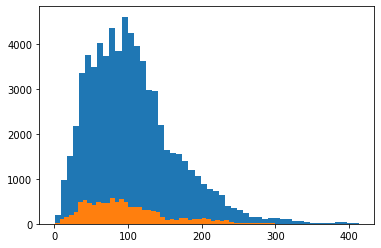

In [86]:
plt.hist(np.abs(oofs_pp['x'].values), bins=50)
plt.hist(np.abs(sub_pp['x'].values), bins=50)
plt.show()

In [84]:
pd.DataFrame(np.abs(oofs_pp['x'].values)).describe().T

,count,mean,std,min,25%,50%,75%,max
0,69809.0,112.689857,66.305873,0.184819,59.125371,101.573235,159.72145,329.78467


In [85]:
pd.DataFrame(np.abs(sub_pp['x'].values)).describe().T

,count,mean,std,min,25%,50%,75%,max
0,10133.0,100.25362,59.953726,3.3604,53.489666,86.27646,138.38644,285.74164


In [78]:
bad_index = np.union1d(np.where(np.abs(train_df['x'].values - oofs_df['x']) > 20)[0], np.where(np.abs(train_df['y'].values - oofs_df['y']) > 20)[0])

In [92]:
np.save(str(OUTPUT_DIR) + f"/oof{EXP_NAME}_badindex.npy", bad_index)

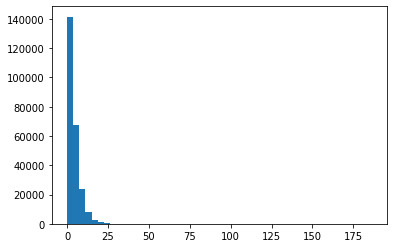

,count,mean,std,min,25%,50%,75%,max
x,245042.0,4.067969,3.780431,0.000015,1.41157,3.084192,5.611626,186.191399


In [76]:
plt.hist(np.abs(train_df['x'].values - oofs_df['x']), bins=50)
plt.show()
pd.DataFrame(np.abs(train_df['x'].values - oofs_df['x'])).describe().T

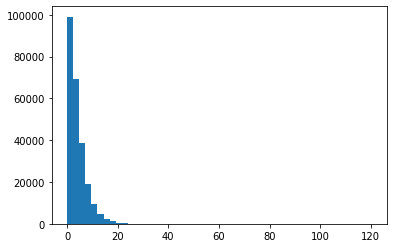

,count,mean,std,min,25%,50%,75%,max
y,245042.0,4.053767,3.723929,0.000053,1.423114,3.092892,5.588755,120.228602


In [77]:
plt.hist(np.abs(train_df['y'].values - oofs_df['y']), bins=50)
plt.show()
pd.DataFrame(np.abs(train_df['y'].values - oofs_df['y'])).describe().T

In [ ]:
import json
import matplotlib.pylab as plt

def plot_preds(
    site,
    floorNo,
    sub=None,
    true_locs=None,
    base=str(DATA_DIR/'indoor-location-navigation'),
    show_train=True,
    show_preds=True,
    fix_labels=True,
    map_floor=None
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    if map_floor is None:
        map_floor = floorNo
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)

    if show_train:
        true_locs = true_locs.query('site == @site and floorNo == @map_floor').copy()
        true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
        true_locs["y_"] = (
            true_locs["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        true_locs.query("site == @site and floorNo == @map_floor").groupby("path").plot(
            x="x_",
            y="y_",
            style="+",
            ax=ax,
            label="train waypoint location",
            color="grey",
            alpha=0.5,
        )

    if show_preds:
        sub = sub.query('site == @site and floorNo == @floorNo').copy()
        sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
        sub["y_"] = (
            sub["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        for path, path_data in sub.query(
            "site == @site and floorNo == @floorNo"
        ).groupby("path"):
            path_data.plot(
                x="x_",
                y="y_",
                style=".-",
                ax=ax,
                title=f"{site} - floor - {floorNo}",
                alpha=1,
                label=path,
            )
    if fix_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
        )
    return fig, ax

In [ ]:
example_site = '5a0546857ecc773753327266'
example_floorNo = 'F1'

sub_df = sub_process(sub_df, train_waypoints)
plot_preds(example_site, example_floorNo, sub_df,
           train_waypoints, show_preds=True)

In [ ]:
plot_preds(example_site, example_floorNo, sub_df_cm,
           train_waypoints, show_preds=True)

In [ ]:
plot_preds(example_site, example_floorNo, sub_pp,
           train_waypoints, show_preds=True)